## ProjF3 - Baseline Model



In [ ]:
# all imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
np.random.seed(42)

### 1. Load and Prepare Data


In [ ]:
#Reading all data and setting all the column names are expected

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names=[f's{i}' for i in range(1,24)]
col_names = index_names + setting_names + sensor_names
rul_names = ['RUL']

train_data = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_train.txt", header=None, sep=" ",names=col_names)
test_data = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_test.txt", header=None, sep=" ",names=col_names)
truth_data = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_truth.txt", header=None, sep=" ",names=col_names)

train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
truth_data.dropna(axis=1, inplace=True)

In [ ]:
# Used to set the RUL value on train and test dataset, RUL = none is for train and not null if for Test set
# Function looks at the breaking cycle and current cycle to determine the RUL value

def prepare_data(df, rul = None):
  df.sort_values(['id', 'cycle'], inplace = True)

  if rul is None:
    rul = pd.DataFrame(train_data.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id' , 'max']

  df = df.merge(rul, on=['id'], how='left')
  df['RUL'] = df['max'] - df['cycle']
  df.drop('max', axis = 1, inplace = True)

  return df

In [ ]:
# Prepare RUL values for Training dataset
train_df = prepare_data(train_data)

In [ ]:
# Data preperation since Truth dataset contains the RUL value for the last cycle and hence we need to use that to determine all cycles RUL values

truth_temp_df = pd.DataFrame(test_data.groupby('id')['cycle'].max()).reset_index()
truth_temp_df.columns = ['id', 'true_rul']
truth_temp_df['max'] = truth_temp_df['true_rul'][:] + truth_data['id'][:]
truth_temp_df.drop(['true_rul'], axis=1, inplace=True)


In [ ]:
# Prepare RUL values for Test dataset
test_df = prepare_data(test_data, rul=truth_temp_df)

In [ ]:


from sklearn.preprocessing import StandardScaler

# For normalizing required columns
def normalize_data(df_train, df_test):

  cols_normalize = df_train.columns.difference(['id','cycle','RUL'])

  min_max_scaler = preprocessing.MinMaxScaler()
  norm_df_train = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]),
                              columns=cols_normalize,
                              index=df_train.index)

  join_df = df_train[['id','cycle','RUL']].join(norm_df_train)
  df_train = join_df.reindex(columns = df_train.columns)

  norm_df_test = pd.DataFrame(min_max_scaler.transform(df_test[cols_normalize]),
                            columns=cols_normalize,
                            index=df_test.index)

  test_join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_df_test)
  df_test = test_join_df.reindex(columns = df_test.columns)
  df_test = df_test.reset_index(drop=True)


  return df_train, df_test

In [ ]:
train_df, test_df = normalize_data(train_df, test_df)

In [ ]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


In [ ]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138


### 2. Prepare your Baseline Model


Since the problem involves predicting Remaining Useful Life (RUL) values, a regressor is required as we are predicting numeric values. We experimented with different regression models including Support Vector Regressor (SVR), Linear Regression, and Polynomial Regression. After thorough testing, we concluded that **Random Forest Regressor** yielded the best performance, although it remains relatively poor.

In [ ]:
# RANDOM FOREST REGRESSOR

X_train_rfg = train_df[train_df.columns.difference(['RUL', id])]
y_train_rfg = train_df[['RUL']]

X_test_rfg = test_df[train_df.columns.difference(['RUL', id])]
y_test_rfg = test_df[['RUL']]

# Tried with multiple depths , 7 gave us the best
ranForReg = RandomForestRegressor(n_estimators=50, max_features=3, max_depth=7, n_jobs=-1, random_state=1)

ranForReg.fit(X_train_rfg, y_train_rfg)

<ipython-input-11-f47db9f8b53a>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ranForReg.fit(X_train_rfg, y_train_rfg)


RandomForestRegressor(max_depth=7, max_features=3, n_estimators=50, n_jobs=-1,
                      random_state=1)


Predicting the Remaining Useful Life (RUL) values has shown poor performance. Therefore, we approached the problem from a different perspective by transforming it into a classification problem. In the context of aircraft maintenance, waiting until the last cycle to conduct engine servicing is impractical. Instead, we need to maintain a buffer to anticipate potential failures at any given point. Using this concept, we binned the RUL values to convert the problem into a classification task.

In [ ]:
# KNN MODEL

# We are going to turn this into a classification problem by predicting what is the severity of the engine, if it requires servicing or not.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For evaluating the accuracy of predictions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true)))


X_train_knn = train_df[train_df.columns.difference(['RUL', id])]
y_train_knn = train_df[['RUL']]

label_map={1:"RISK ZONE",2:"MODERATED RISK",3:"NO RISK"}

# Binning of RUL values into the above label map
def _conditions(col_series):
  return [
        (col_series <= 30),
        (col_series > 31) & (col_series <= 100),
        (col_series > 100)
    ]

choices = [1, 2, 3]

y_train_knn.loc[:, 'RUL'] = np.select(_conditions(y_train_knn['RUL']), choices, default=3)

X_test_knn = test_df[test_df.columns.difference(['RUL'])]
y_test_knn = test_df[['RUL']]

y_test_knn.loc[:, 'RUL'] = np.select(_conditions(y_test_knn['RUL']), choices, default=3)

# Verifying that all values have been binned
unique_values, counts = np.unique(y_train_knn, return_counts=True)
print(unique_values, counts)
unique_values, counts = np.unique(y_test_knn, return_counts=True)
print(unique_values, counts)

[1 2 3] [ 3100  6900 10631]
[1 2 3] [ 332 2837 9927]


In [ ]:
#Fitting the training dataset with

knn=KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_knn,np.array(y_train_knn))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=100)

### 3. Baseline Performance


In [ ]:
# RANDOM FOREST REGRESSOR (Poor Performance)

y_test_rfg_predict = ranForReg.predict(X_test_rfg)
y_train_rfg_predict = ranForReg.predict(X_train_rfg)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train_rfg, y_train_rfg_predict)),
      (metrics.r2_score(y_test_rfg, y_test_rfg_predict))))

ranForReg_metrics = ranForReg.score(X_test_rfg, y_test_rfg)

R^2 training: 0.734, R^2 test: 0.496


In [ ]:
x = 70
y_test_rfg_predict[x], y_test_rfg['RUL'][x]


(147.35352099745288, 107)

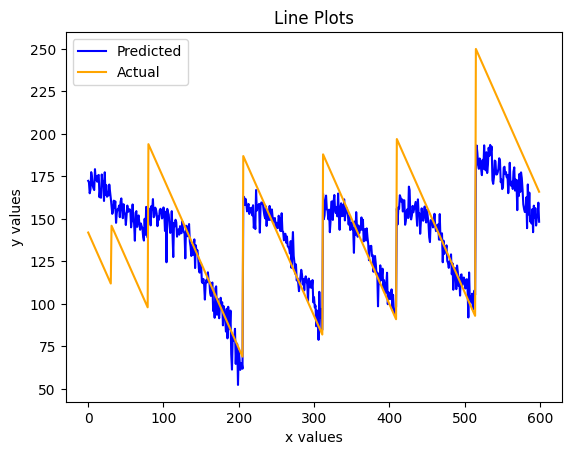

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.plot(y_test_rfg_predict[0:600], label='Predicted', color='blue')
plt.plot(y_test_rfg['RUL'][0:600], label='Actual', color='orange', )

plt.title('Line Plots')
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()

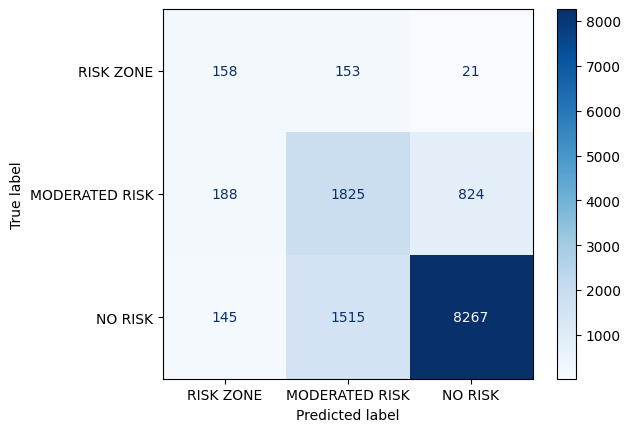

0.7491638795986622
KNN
Accuracy score of training dataset  0.7491638795986622
Error rate of training dataset  0.153959252257929
Accuracy score of test dataset  0.7826817348808797
Error rate of test dataset 0.09947057625738137
              precision    recall  f1-score   support

           1       0.32      0.48      0.38       332
           2       0.52      0.64      0.58      2837
           3       0.91      0.83      0.87      9927

    accuracy                           0.78     13096
   macro avg       0.58      0.65      0.61     13096
weighted avg       0.81      0.78      0.79     13096



In [ ]:
# KNN PERFORMANCE

y_knn_test= knn.predict(X_test_knn)
y_knn_train= knn.predict(X_train_knn)

from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, classification_report

cm= confusion_matrix(y_test_knn, y_knn_test, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]],label_map[knn.classes_[1]],label_map[knn.classes_[2]]])
disp.plot(cmap='Blues')
plt.show()

print(accuracy_score(y_train_knn, y_knn_train))

# Measure the performance
print('KNN')
print("Accuracy score of training dataset ", accuracy_score(y_train_knn, y_knn_train))
print("Error rate of training dataset ", mean_absolute_percentage_error(y_train_knn,y_knn_train))
print("Accuracy score of test dataset ", accuracy_score(y_test_knn, y_knn_test))
print("Error rate of test dataset", mean_absolute_percentage_error(y_test_knn,y_knn_test))

print(classification_report(y_test_knn,y_knn_test))